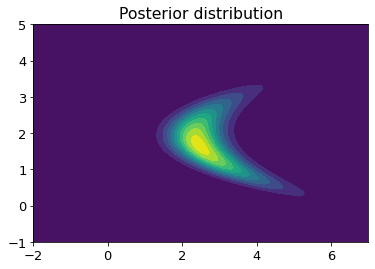

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt, pi, exp
import scipy.linalg
import time
import matplotlib.pylab as pl
from scipy.sparse.linalg import eigs
import math

import functools

from eki_code.grad_inference import *

np.random.seed(1)

alpha = 1.0
J = 20  # number of particles 
N_sim = 20000 # number of iterations
d = 2 # dimension
tau = 0.01 # step size
u0 = np.random.normal(0,1.0,(2,J)) # initial positions of the particles

# test case "banana"
y = 0
sigNoise = 0.5
sigPrior = 2



G = lambda u: ((u[1]-2)**2-(u[0]-3.5) -1)
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
I = lambda u: Phi(u) + 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2


# Plot test case
xmin = -2
xmax = 7
ymin= -1
ymax= 5
u0s = np.linspace(xmin,xmax,150)
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1))

plt.figure()
plt.contourf(U0, U1, np.exp(-I(U)), 10)
plt.title("Posterior distribution")

unnorm_dens = np.exp(-I(U))
Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

# method for computing all gradients at once
def compute_gradients(points):
    vs = np.zeros_like(points)
    d, J = points.shape
    H = np.zeros((points.shape[0],points.shape[0],points.shape[1]))
    for i in range(J):
        return_dict= inferGradientAndHess(points, I(points), hessian = True, ind=i, additionalvariance=0.0)
        vs[:,i], H[:,:,i] = return_dict['grad'], return_dict['H']
    return vs, H


In [32]:
# ULA (Unadjusted Langevin Algorithm)
"""
start_time = time.time()
us_list_ULA = np.zeros((2,J,N_sim)) # 2, number of particles, number of iterations
us_list_ULA[:,:,0] = u0 # initial positions on the grid


for n in range(N_sim-1):    
    us = us_list_ULA[:,:,n]
    vs, H = compute_gradients(us_list_ULA[:,:,n])
    tauk = tau * np.linalg.norm(us, axis=0)/(1e-3+np.linalg.norm(vs, axis=0))
    us_list_ULA[:,:,n+1] = us_list_ULA[:,:,n] - tauk*alpha*vs + sqrt(2)*(tauk**(1/2))*np.random.normal(0,1,(2,J))

print(f"ULA: {time.time()-start_time} seconds")
"""

'\nstart_time = time.time()\nus_list_ULA = np.zeros((2,J,N_sim)) # 2, number of particles, number of iterations\nus_list_ULA[:,:,0] = u0 # initial positions on the grid\n\n\nfor n in range(N_sim-1):    \n    us = us_list_ULA[:,:,n]\n    vs, H = compute_gradients(us_list_ULA[:,:,n])\n    tauk = tau * np.linalg.norm(us, axis=0)/(1e-3+np.linalg.norm(vs, axis=0))\n    us_list_ULA[:,:,n+1] = us_list_ULA[:,:,n] - tauk*alpha*vs + sqrt(2)*(tauk**(1/2))*np.random.normal(0,1,(2,J))\n\nprint(f"ULA: {time.time()-start_time} seconds")\n'

In [33]:
# EKS 2 (ALDI with gradient)
start_time = time.time()
us_list_ALDI = np.zeros((d,J,N_sim))
us_list_ALDI[:,:,0] = u0
total_acc = 0
tau_ALDI = tau

y_algo = np.array([[y]])
for n in range(N_sim-1):   
    us = us_list_ALDI[:,:,n] # shape (d, J)
    m_us = np.mean(us, axis=1)[:,np.newaxis] # shape (d, 1)
    G_us_unprocessed = G(us)
    #if G_us_unprocessed.ndim == 1: # this is just to catch an annoying thing when G has higher dimension
    G_us = G_us_unprocessed[np.newaxis,:] # shape (1, J)
    m_G_us = np.mean(G_us, axis=1)[np.newaxis, :] # shape (1, 1)
    #else:
    #    G_us = G_us_unprocessed.Ts
    #    m_G_us = np.mean(G_us, axis=1)[:,np.newaxis]
    #m_G_us =  np.mean(G(us)[np.newaxis,:], axis=1)[np.newaxis, :]
    u_c = us - m_us 
    g_c = G_us - m_G_us
    D = 1/J*np.einsum('ij,lj->il', u_c, g_c) # shape (d, 1)
    C = np.cov(us)*(J-1)/J # shape (2, 2)
    E = np.cov(G_us)*(J-1)/J # scalar for dimension of G=1
    Csqrt = 1/sqrt(J)*u_c # shape (d, J)
    
    vs, H = compute_gradients(us) # vs: shape (d, J)
    
    #drift = -1/(sigNoise**2 + tau_ALDI*E)*D@(G_us-y_algo) - 1/sigPrior**2*C@us + (d+1)*1/J*(us-m_us) # original line
    drift = - np.dot(C,vs) + (d+1)*1/J*(us-m_us) # shape (d,J)
    noise = np.random.normal(0,1,(J,J)) # shape (J,J)
    diff = sqrt(2)*Csqrt@noise # shape (d,J)

    us_list_ALDI[:,:,n+1] = us+tau_ALDI*drift  + sqrt(tau_ALDI)*diff
print(f"ALDI: {time.time()-start_time} seconds")

ALDI: 192.18058228492737 seconds


In [38]:
C.shape

(2, 2)

In [34]:
diff.shape

(2, 20)

'\nplt.figure()\nplt.pcolormesh(yedges3, xedges3, H3.T, cmap=pl.cm.viridis_r); \nplt.xlim((xmin,xmax))\nplt.ylim((ymin,ymax))\nplt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")\nplt.title("Non Reversible Ensemble Kalman Sampler, J = "+str(J)+", N = "+str(N_sim))\n'

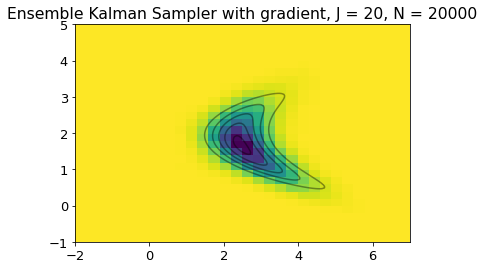

In [36]:

N_burnin = 0#1000#int(N_sim/2)

binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)
#H1, yedges1, xedges1 = np.histogram2d(us_list_ULA[0,:,N_burnin:].flatten(),us_list_ULA[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
H2, yedges2, xedges2 = np.histogram2d(us_list_ALDI[0,:,N_burnin:].flatten(),us_list_ALDI[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
#H3, yedges3, xedges3 = np.histogram2d(us_list_ALDINR[0,:,N_burnin:].flatten(),us_list_ALDINR[1,:,N_burnin:].flatten(), bins=[binsx,binsy])


"""
plt.figure()
plt.pcolormesh(yedges1, xedges1, H1.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Langevin Sampler, J = "+str(J)+", N = "+str(N_sim))
"""

plt.figure()
plt.pcolormesh(yedges2, xedges2, H2.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Ensemble Kalman Sampler with gradient, J = "+str(J)+", N = "+str(N_sim))

"""
plt.figure()
plt.pcolormesh(yedges3, xedges3, H3.T, cmap=pl.cm.viridis_r); 
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black")
plt.title("Non Reversible Ensemble Kalman Sampler, J = "+str(J)+", N = "+str(N_sim))
"""

In [37]:
us_list_ALDI

array([[[ 1.62434536,  1.97418678,  2.15318455, ...,  3.16194805,
          3.09518086,  3.23766457],
        [-0.61175641, -0.5080397 , -0.1275592 , ...,  1.98090807,
          1.9246447 ,  1.99915441],
        [-0.52817175, -0.39100704, -0.15928215, ...,  1.93740235,
          2.0222096 ,  2.01712902],
        ...,
        [-0.87785842, -0.69828695, -0.6427247 , ...,  3.81381542,
          3.79860208,  3.83382976],
        [ 0.04221375,  0.24685785,  0.21096493, ...,  2.39552723,
          2.43708794,  2.40084139],
        [ 0.58281521,  0.56621948,  0.47359223, ...,  3.39579014,
          3.43041298,  3.30594924]],

       [[-1.10061918,  0.44874044,  0.49580493, ...,  1.82418796,
          1.9239087 ,  1.82264121],
        [ 1.14472371,  1.45966567,  1.39356295, ...,  1.55806092,
          1.46318004,  1.43405782],
        [ 0.90159072,  1.31249723,  1.321685  , ...,  1.91077775,
          1.94669993,  2.05540808],
        ...,
        [ 0.2344157 ,  0.88224489,  0.85523272, ...,  